In [1]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os
import time
import json

/home/zdm/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = 'cpu'

In [3]:
# 设置环境变量避免警告
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [5]:
# 设置matplotlib使用math text
plt.rcParams['axes.formatter.use_mathtext'] = True
# 如果需要更完整的数学字体设置，可以添加：
plt.rcParams['mathtext.fontset'] = 'cm'  # 使用Computer Modern字体
plt.rcParams['font.family'] = 'STIXGeneral'  # 使用STIX字体族

In [6]:
def lsh_compress(vector, random_projections):
    """将向量压缩为256位整数"""
    projections = np.dot(vector, random_projections.T)
    binary = (projections > 0).astype(int)
    compressed = 0
    for i, bit in enumerate(binary):
        if bit:
            compressed |= (1 << i)
    return compressed

def hamming_similarity(a, b):
    """计算两个压缩向量的相似度"""
    xor = a ^ b
    hamming_distance = bin(xor).count('1')
    return (256 - hamming_distance) / 256.0

# 文本

In [7]:
def load_texts_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # 展平所有文本
    texts = []
    for similarity_level in data.values():
        for group in similarity_level:
            texts.extend(group['texts'])
    return texts

In [8]:
def compute_similarities(model, texts):
    # 4. 进行实验
    # 提取文本特征
    features = model.encode(texts, normalize_embeddings=True)

    # 准备随机投影矩阵
    dim = features.shape[1]  # 384 for bge-small
    n_projections = 256
    np.random.seed(10)  # 固定随机种子
    random_projections = np.random.randn(n_projections, dim)

    # 压缩特征
    compressed_features = [lsh_compress(feat, random_projections) for feat in features]

    # 批量计算原始相似度
    original_similarities = cosine_similarity(features)
    original_similarities = original_similarities[np.triu_indices(len(features), k=1)]

    # 计算压缩后的相似度
    compressed_similarities = []
    for i in range(len(compressed_features)):
        for j in range(i+1, len(compressed_features)):
            comp_sim = hamming_similarity(compressed_features[i], compressed_features[j])
            compressed_similarities.append(comp_sim)
    compressed_similarities = np.array(compressed_similarities)
            
    return original_similarities, compressed_similarities

In [9]:
# 导入数据
texts = load_texts_json('texts.json')

In [10]:
len(texts)

200

In [13]:
model_results = {}

## MiniLM

In [14]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# model = SentenceTransformer('/home/zdm/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/c9745ed1d9f207416be6d2e6f8de32d1f16199bf')

In [15]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [16]:
start = time.time()
orig_sims_minilm, comp_sims_minilm = compute_similarities(model, texts)
end = time.time()
model_results.update({'MiniLM-L6-v2': (orig_sims_minilm, comp_sims_minilm)})
print(f"time: {end - start:.4f} seconds")

time: 2.4993 seconds


## MPNet

In [44]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
# model = SentenceTransformer('/home/zdm/.cache/huggingface/hub/models--sentence-transformers--all-mpnet-base-v2/snapshots/e8c3b32edf5434bc2275fc9bab85f82640a19130')

In [45]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [46]:
start = time.time()
orig_sims_mpnet, comp_sims_mpnet = compute_similarities(model, texts)
end = time.time()
model_results.update({'MPNet-base-v2': (orig_sims_mpnet, comp_sims_mpnet)})
print(f"time: {end - start:.4f} seconds")

time: 15.6390 seconds


## 合并画图

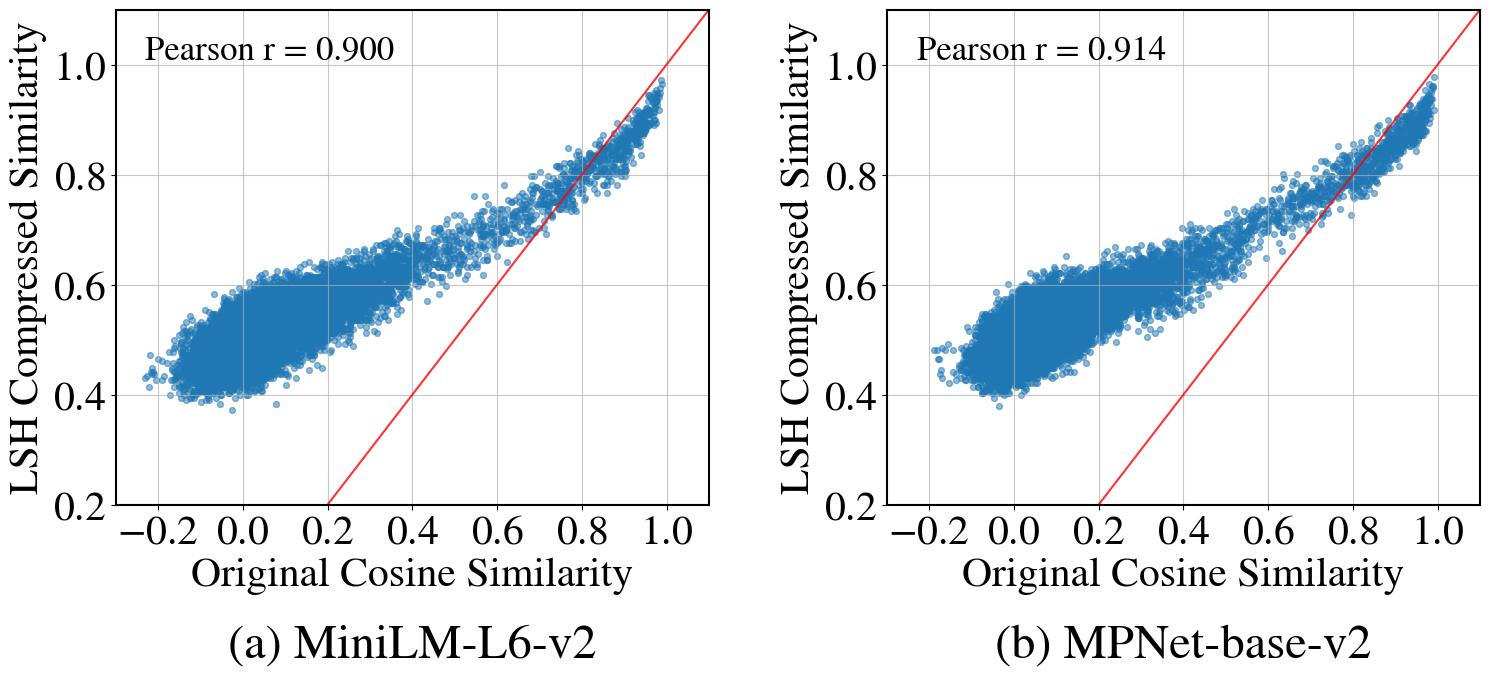

In [639]:
# 创建1x2的子图布局
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 修改为1行2列，调整figsize

models = [('MiniLM-L6-v2', 0), ('MPNet-base-v2', 1)]  # 简化索引，只需要列索引

for model_name, j in models:
    orig_sims, comp_sims = model_results[model_name]
    ax = axes[j]  # 现在axes是一维的
    
    # 绘制散点图
    ax.scatter(orig_sims, comp_sims, alpha=0.5, s=18)
    ax.tick_params(axis='both', labelsize=30)

    # 设置刻度间隔为0.2
    ax.set_xticks(np.arange(-0.2, 1.2, 0.2))
    ax.set_yticks(np.arange(-0.2, 1.2, 0.2))
    
    # 设置标签
    ax.set_xlabel('Original Cosine Similarity', fontsize=30)
    ax.set_ylabel('LSH Compressed Similarity', fontsize=30)
    
    # 计算pearson相关系数
    pearson = np.corrcoef(orig_sims, comp_sims)[0,1]
    
    # 设置标题在底部
    ax.set_title(f'({chr(97+j)}) {model_name}', pad=15, y=-0.35, fontsize=35)
    
    # 添加对角线
    ax.plot([-0.2, 1.1], [-0.2, 1.1], 'r-', alpha=0.8)
    
    # 添加相关系数文本
    ax.text(0.05, 0.9, f'Pearson r = {pearson:.3f}', 
            transform=ax.transAxes,
            # bbox=dict(facecolor='white', edgecolor='black', alpha=0.8),
            fontsize=25)

    # 设置网格线
    ax.grid(True, linestyle='-', alpha=0.7)

    # 设置边框线宽
    [i.set_linewidth(1.5) for i in ax.spines.values()]

    # 设置坐标轴范围（确保网格线显示完整）
    ax.set_xlim(-0.3, 1.1)
    ax.set_ylim(0.2, 1.1)

# 调整子图布局
plt.tight_layout()
plt.subplots_adjust(
    bottom=0.15,  # 底部边距
    wspace=0.3    # 子图之间的水平间距
)
plt.savefig(f'./figs/lsh text.png', dpi=300, bbox_inches='tight')
plt.show()

# 图像

In [58]:
from transformers import CLIPProcessor, CLIPModel
from transformers import AutoImageProcessor, AutoModel
from transformers import AutoImageProcessor, SwinModel
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import torchvision.transforms.functional as F
import random
from PIL import Image, ImageEnhance
import requests
import numpy as np
import matplotlib.pyplot as plt

In [59]:
def create_similar_images(image, num_variations=10):
    variations = [image]  # 原图
    
    # 定义变化范围
    ranges = {
        'rotation': (-3, 3),  # 旋转角度范围
        'brightness': (0.93, 1.07),  # 亮度调整范围
        'contrast': (0.93, 1.07),  # 对比度调整范围
        'color': (0.95, 1.05),  # 色彩饱和度范围
        'sharpness': (0.95, 1.05),  # 锐度调整范围
        'scale': (0.98, 1.02),  # 缩放范围
        'noise': (0.01, 0.02)  # 噪声强度范围
    }
    
    # 1. 随机旋转
    angle = random.uniform(ranges['rotation'][0], ranges['rotation'][1])
    if angle != 0:  # 避免0度旋转
        rotated = image.rotate(angle, expand=False)
        variations.append(rotated)
    
    # 2. 随机亮度
    enhancer = ImageEnhance.Brightness(image)
    brightness_factor = random.uniform(ranges['brightness'][0], ranges['brightness'][1])
    variations.append(enhancer.enhance(brightness_factor))
    
    # 3. 随机对比度
    enhancer = ImageEnhance.Contrast(image)
    contrast_factor = random.uniform(ranges['contrast'][0], ranges['contrast'][1])
    variations.append(enhancer.enhance(contrast_factor))
    
    # 4. 随机平移
    width, height = image.size
    offset = random.choice([(1,0), (-1,0), (0,1), (0,-1), (1,1), (-1,-1)])
    shifted = Image.new(image.mode, (width, height))
    shifted.paste(image, offset)
    variations.append(shifted)
    
    # 5. 随机色彩饱和度
    enhancer = ImageEnhance.Color(image)
    color_factor = random.uniform(ranges['color'][0], ranges['color'][1])
    variations.append(enhancer.enhance(color_factor))
    
    # 6. 随机锐度
    enhancer = ImageEnhance.Sharpness(image)
    sharpness_factor = random.uniform(ranges['sharpness'][0], ranges['sharpness'][1])
    variations.append(enhancer.enhance(sharpness_factor))
    
    # 7. 随机裁剪
    crop_size = 2
    left = random.choice([0, crop_size])
    top = random.choice([0, crop_size])
    cropped = image.crop((left, top, width, height))
    resized = cropped.resize((width, height))
    variations.append(resized)
    
    # 8. 随机缩放
    scale = random.uniform(ranges['scale'][0], ranges['scale'][1])
    new_size = (int(width * scale), int(height * scale))
    scaled = image.resize(new_size)
    if scale < 1:
        scaled = scaled.resize((width, height))
    else:
        left = (new_size[0] - width) // 2
        top = (new_size[1] - height) // 2
        scaled = scaled.crop((left, top, left + width, top + height))
    variations.append(scaled)
    
    # 9. 随机噪声
    noise_factor = random.uniform(ranges['noise'][0], ranges['noise'][1])
    img_array = np.array(image)
    noise = np.random.normal(0, noise_factor * 255, img_array.shape)
    noisy_img = np.clip(img_array + noise, 0, 255).astype(np.uint8)
    variations.append(Image.fromarray(noisy_img))
    
    return variations

In [60]:
def load_cifar10_with_variations(num_original_images=100):
    """加载CIFAR10图片并创建变体"""
    # 加载原始图片
    transform = transforms.ToTensor()
    dataset = torchvision.datasets.CIFAR10(
        root='./data', 
        train=False,
        download=True,
        transform=transform
    )
    
    # 随机选择图片
    selected_indices = torch.randperm(len(dataset))[:num_original_images]
    
    # 收集原始图片和变体
    all_images = []
    for idx in selected_indices:
        image, _ = dataset[idx]
        # 转换为PIL图像
        image = transforms.ToPILImage()(image)
        # 创建变体
        variations = create_similar_images(image)
        all_images.extend(variations)
    
    return all_images

In [61]:
# 加载CIFAR-10图片
print("Loading CIFAR-10 images...")
images = load_cifar10_with_variations(num_original_images=100)

Loading CIFAR-10 images...
Files already downloaded and verified


In [62]:
len(images)

1000

## DINOv2

In [63]:
# 加载模型
path = 'facebook/dinov2-base'
# path = '/home/zdm/.cache/huggingface/hub/models--facebook--dinov2-base/snapshots/f9e44c814b77203eaa57a6bdbbd535f21ede1415'
processor = AutoImageProcessor.from_pretrained(path)
model = AutoModel.from_pretrained(path)

In [64]:
# 提取特征
print("Extracting features...")
features_list = []
batch_size = 32

for i in tqdm(range(0, len(images), batch_size)):
    batch_images = images[i:i + batch_size]

    with torch.no_grad():
        # 处理批次
        inputs = processor(images=batch_images, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # 提取特征 - DinoV2的主要区别在这里
        outputs = model(**inputs)
        features = outputs.last_hidden_state[:, 0]  # 获取CLS token的特征
        features = features / features.norm(dim=1, keepdim=True)  # 标准化
        features_list.append(features.cpu().numpy())

# 合并所有特征
features = np.vstack(features_list)

Extracting features...


100%|███████████████████████████████████████████████████████████████████████████████████████| 32/32 [21:51<00:00, 40.97s/it]


In [65]:
features.shape

(1000, 768)

In [67]:
# LSH压缩
dim = features.shape[1]
np.random.seed(42)
n_projections = 256
random_projections = np.random.randn(n_projections, dim)
compressed_features = [lsh_compress(feat, random_projections) for feat in features]

In [68]:
# 计算相似度
orig_sims_dinov2 = cosine_similarity(features)
orig_sims_dinov2 = orig_sims_dinov2[np.triu_indices(len(features), k=1)]

comp_sims_dinov2 = []
for i in range(len(compressed_features)):
    for j in range(i+1, len(compressed_features)):
        sim = hamming_similarity(compressed_features[i], compressed_features[j])
        comp_sims_dinov2.append(sim)
comp_sims_dinov2 = np.array(comp_sims_dinov2)

In [69]:
model_results.update({'DINOv2-base': (orig_sims_dinov2, comp_sims_dinov2)})

## Swin Transformer

In [70]:
# 加载模型
path = "microsoft/swin-base-patch4-window7-224"
# path = '/home/zdm/.cache/huggingface/hub/models--microsoft--swin-base-patch4-window7-224/snapshots/20d6c26ef6455d36c0a78671d787c5da57513d4b'
processor = AutoImageProcessor.from_pretrained(path)
model = SwinModel.from_pretrained(path).to(device)

In [71]:
# 提取特征
print("Extracting features...")
features_list = []
batch_size = 32

for i in tqdm(range(0, len(images), batch_size)):
    batch_images = images[i:i + batch_size]

    with torch.no_grad():
        # 处理批次
        inputs = processor(images=batch_images, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # 提取特征 - Swin的输出方式不同
        outputs = model(**inputs)
        # 使用pooled输出作为特征
        features = outputs.pooler_output
        # 标准化
        features = features / features.norm(dim=1, keepdim=True)
        features_list.append(features.cpu().numpy())

# 合并所有特征
features = np.vstack(features_list)

Extracting features...


100%|███████████████████████████████████████████████████████████████████████████████████████| 32/32 [15:32<00:00, 29.14s/it]


In [72]:
features.shape

(1000, 1024)

In [73]:
# LSH压缩
dim = features.shape[1]
np.random.seed(42)
random_projections = np.random.randn(n_projections, dim)
compressed_features = [lsh_compress(feat, random_projections) for feat in features]

In [74]:
# 计算相似度
orig_sims_swin = cosine_similarity(features)
orig_sims_swin = orig_sims_swin[np.triu_indices(len(features), k=1)]

comp_sims_swin = []
for i in range(len(compressed_features)):
    for j in range(i+1, len(compressed_features)):
        sim = hamming_similarity(compressed_features[i], compressed_features[j])
        comp_sims_swin.append(sim)
comp_sims_swin = np.array(comp_sims_swin)

In [75]:
model_results.update({'Swin Transformer-base': (orig_sims_swin, comp_sims_swin)})

## 合并画图

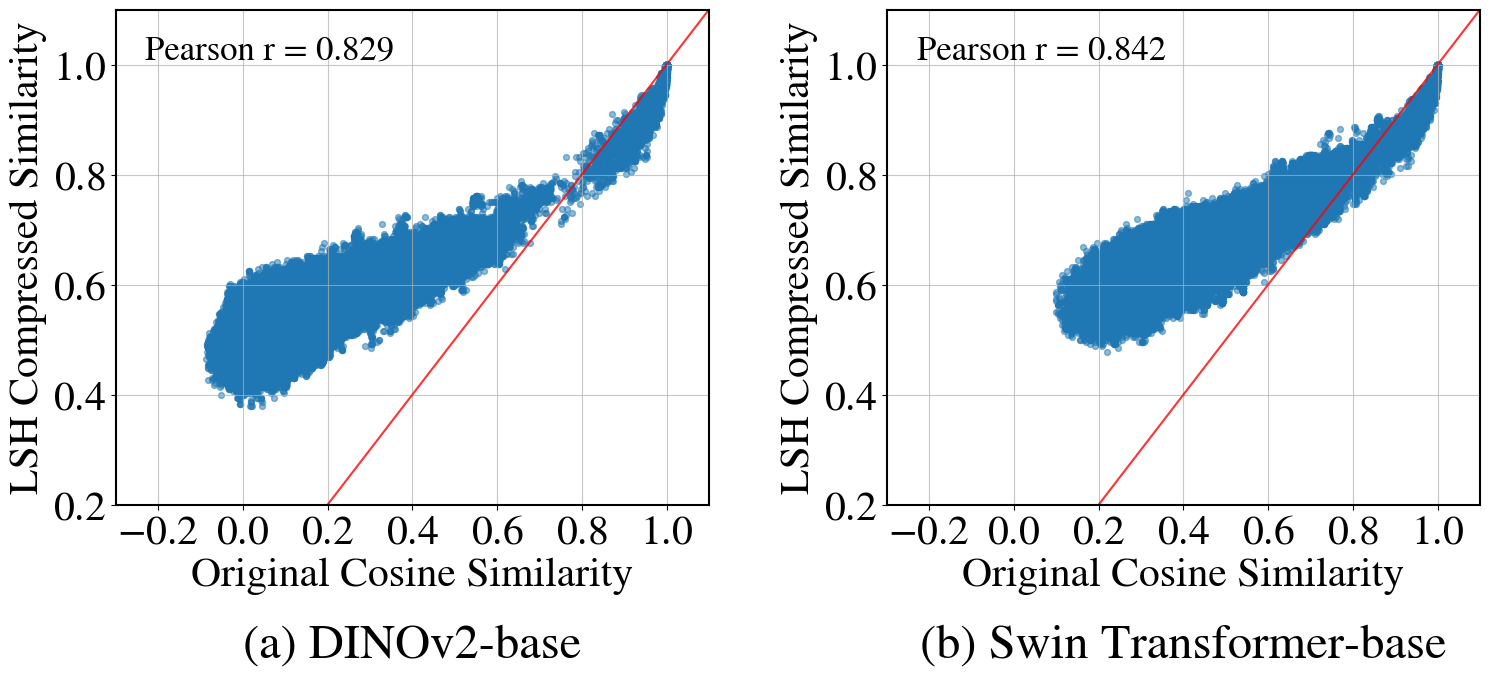

In [640]:
# 创建1x2的子图布局
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 修改为1行2列，调整figsize

models = [('DINOv2-base', 0), ('Swin Transformer-base', 1)]  # 简化索引，只需要列索引

for model_name, j in models:
    orig_sims, comp_sims = model_results[model_name]
    ax = axes[j]  # 现在axes是一维的
    
    # 绘制散点图
    ax.scatter(orig_sims, comp_sims, alpha=0.5, s=18)
    ax.tick_params(axis='both', labelsize=30)

    # 设置刻度间隔为0.2
    ax.set_xticks(np.arange(-0.2, 1.2, 0.2))
    ax.set_yticks(np.arange(-0.2, 1.2, 0.2))
    
    # 设置标签
    ax.set_xlabel('Original Cosine Similarity', fontsize=30)
    ax.set_ylabel('LSH Compressed Similarity', fontsize=30)
    
    # 计算pearson相关系数
    pearson = np.corrcoef(orig_sims, comp_sims)[0,1]
    
    # 设置标题在底部
    ax.set_title(f'({chr(97+j)}) {model_name}', pad=15, y=-0.35, fontsize=35)
    
    # 添加对角线
    ax.plot([-0.2, 1.1], [-0.2, 1.1], 'r-', alpha=0.8)
    
    # 添加相关系数文本
    ax.text(0.05, 0.9, f'Pearson r = {pearson:.3f}', 
            transform=ax.transAxes,
            # bbox=dict(facecolor='white', edgecolor='black', alpha=0.8),
            fontsize=25)

    # 设置网格线
    ax.grid(True, linestyle='-', alpha=0.7)

    # 设置边框线宽
    [i.set_linewidth(1.5) for i in ax.spines.values()]

    # 设置坐标轴范围（确保网格线显示完整）
    ax.set_xlim(-0.3, 1.1)
    ax.set_ylim(0.2, 1.1)

# 调整子图布局
plt.tight_layout()
plt.subplots_adjust(
    bottom=0.15,  # 底部边距
    wspace=0.3    # 子图之间的水平间距
)
plt.savefig(f'./figs/lsh image.png', dpi=300, bbox_inches='tight')
plt.show()

# 阈值敏感性

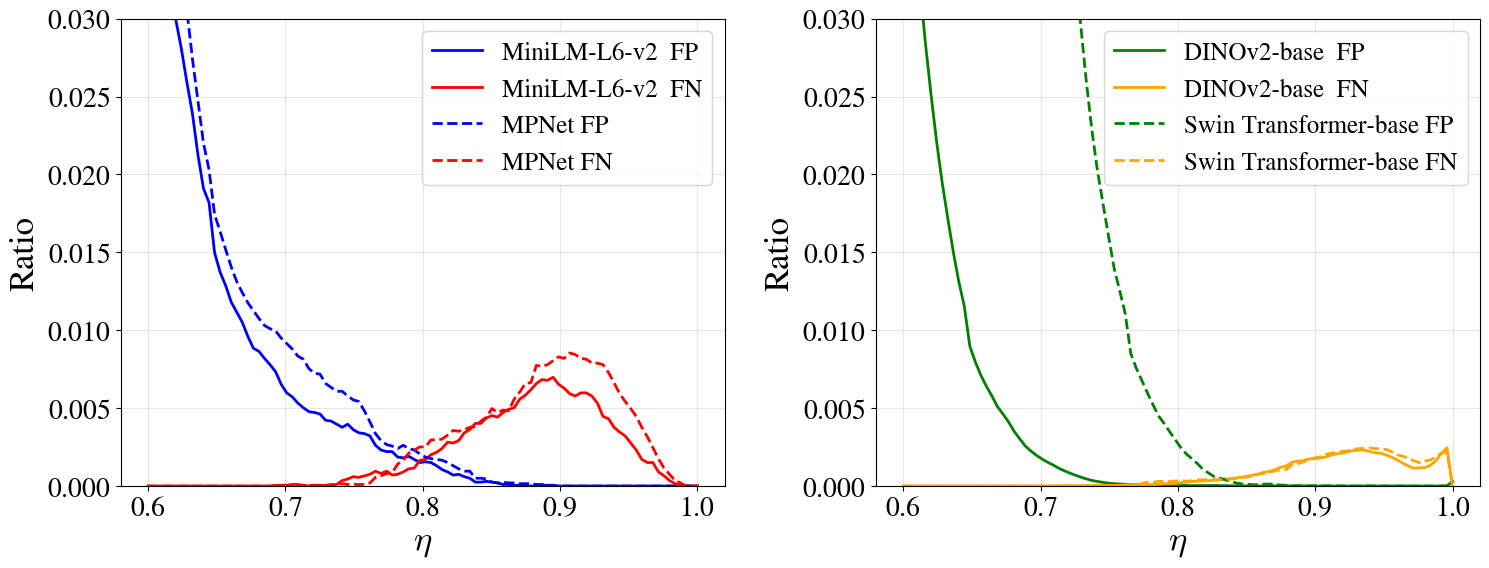

In [107]:
def scan_fp_fn(comp, orig, etas):
    fp, fn = [], []
    for eta in etas:
        fp_mask = (comp >= eta) & (orig < eta)
        fn_mask = (comp <  eta) & (orig >= eta)
        fp.append(fp_mask.sum() / len(fp_mask))
        fn.append(fn_mask.sum() / len(fn_mask))
    return np.array(fp), np.array(fn)

etas = np.linspace(0.6, 1, 100)

# 扫描四组模型
fp_mn, fn_mn = scan_fp_fn(comp_sims_minilm, orig_sims_minilm, etas)
fp_mp, fn_mp = scan_fp_fn(comp_sims_mpnet,  orig_sims_mpnet,  etas)
fp_dv, fn_dv = scan_fp_fn(comp_sims_dinov2, orig_sims_dinov2, etas)
fp_sw, fn_sw = scan_fp_fn(comp_sims_swin,   orig_sims_swin,   etas)

# ---------- 画图 ----------
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ---- 左图：MiniLM-L6-v2  vs  MPNet-base-v2 ----
ax = axes[0]
ax.plot(etas, fp_mn, label='MiniLM-L6-v2  FP', lw=2, color='b', linestyle='-')
ax.plot(etas, fn_mn, label='MiniLM-L6-v2  FN', lw=2, color='r', linestyle='-')
ax.plot(etas, fp_mp, label='MPNet FP', lw=2, color='b', linestyle='--')
ax.plot(etas, fn_mp, label='MPNet FN', lw=2, color='r', linestyle='--')
ax.set_xlabel(r'$\eta$', fontsize=25)
ax.set_ylabel('Ratio', fontsize=25)
# ax.set_title('(a) MiniLM-L6-v2 vs. MPNet', y=-0.15, fontsize=30)
ax.legend(fontsize=18)
ax.grid(alpha=0.3)
ax.tick_params(labelsize=20)
# ax.set_yscale('log')
# ax.set_ylim(1e-10, 1e-1)      # 举例：0.01 % – 100 %

# ---- 右图：DINOv2-base  vs  Swin Transformer-base ----
ax = axes[1]
ax.plot(etas, fp_dv, label='DINOv2-base  FP', lw=2, color='g', linestyle='-')
ax.plot(etas, fn_dv, label='DINOv2-base  FN', lw=2, color='orange', linestyle='-')
ax.plot(etas, fp_sw, label='Swin Transformer-base FP', lw=2, color='g', linestyle='--')
ax.plot(etas, fn_sw, label='Swin Transformer-base FN', lw=2, color='orange', linestyle='--')
ax.set_xlabel(r'$\eta$', fontsize=25)
ax.set_ylabel('Ratio', fontsize=25)
# ax.set_title('(b) DINOv2-base vs. Swin-T-base', y=-0.15, fontsize=30)
ax.legend(fontsize=18)
ax.grid(alpha=0.3)
ax.tick_params(labelsize=20)
# ax.set_yscale('log')
# ax.set_ylim(1e-10, 1e-1)      # 举例：0.01 % – 100 %

plt.setp(axes, ylim=(0, 0.03))
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, bottom=0.18)
plt.savefig('./figs/eta.png', dpi=300, bbox_inches='tight')
plt.show()